In [61]:
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from segmentacion.globalT import thresholdingGlobal
from bordes import minimum_circular_shift
from formas_binarias import first_difference
from collections import Counter
#from bordes import trace_boundary
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def loadDataset(fileName, samples):
    x = []
    y = []
    train_data = pd.read_csv(fileName)
    y = np.array(train_data.iloc[0:samples, 0])
    x = np.array(train_data.iloc[0:samples, 1:])
    return x,y

In [ ]:
def dilatacion(A, B):
    m, n = A.shape
    p, q = B.shape
    C = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for k in range(p):
                for l in range(q):
                    if B[k, l] == 1 and i+k-p//2 >= 0 and i+k-p//2 < m and j+l-q//2 >= 0 and j+l-q//2 < n:
                        C[i, j] = max(C[i, j], A[i+k-p//2, j+l-q//2])
                        

    return C

def erosion(imagen, kernel):
    altura, ancho = imagen.shape
    m, n = kernel.shape
    resultado = np.zeros((altura, ancho))
    
    for i in range(m//2, altura-m//2):
        for j in range(n//2, ancho-n//2):
            # Realizar la operación de erosión
            if (imagen[i-m//2:i+m//2+1, j-n//2:j+n//2+1] * kernel).min() >= 1:
                resultado[i, j] = 1
    
    return resultado
kernel = np.ones((3,3),np.uint8)


(100, 784)
(100,)
1


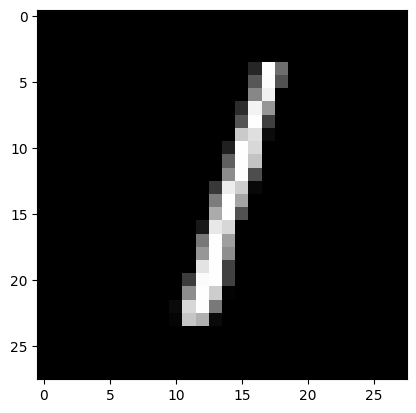

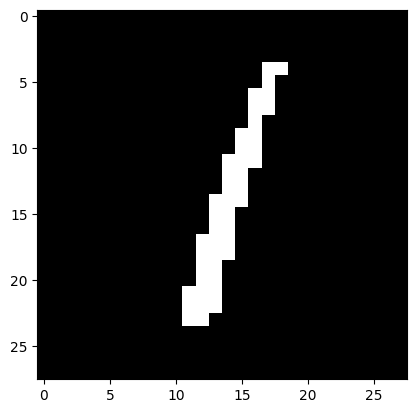

In [27]:
x,y=loadDataset("Nmist/mnist_test.csv",100)
indice = 1

print(x.shape)
print(y.shape)
print(y[indice])
digit = x[indice]

digit_pixels = digit.reshape(28, 28)
plt.imshow(digit_pixels, cmap='gray')
plt.show()


binary  = thresholdingGlobal(digit_pixels,45)
#plt.imshow(bin, cmap='gray')
#plt.show()
binary = erosion(dilatacion(binary,kernel),kernel)

#plt.show()
#binary = dilatacion(erosion(binary,kernel),kernel)
#plt.imshow(binary2, cmap='gray')
plt.imshow(binary, cmap='gray')
plt.show()

In [55]:
def next_index_in_neighbourhood(x, y, connectivity, direction):
  """Get next index in the neighbourhood of a pixel at (x, y).

  Args:
    x: int. Vertical index (row index).
    y: int. Horizontal index (column index).
    connectivity: int. 4 or 8, depending on the neighbourhood connectivity.
    direction: int. A number indicating the direction according to a
               connectivity matrix.

               For 4-connectivity, the direction is

                   1
                   |
               2-(x,y)-0
                   |
                   3

               For 8-connectivity, the direction is

               3   2   1
                \  |  /
               4-(x,y)-0
                /  |  \
               5   6   7

  Returns:
    new_x: int. New vertical index.
    new_y: int. New horizontal index.

  """
  dx, dy = dir_to_coord(direction, connectivity)
  next_x = x + dx
  next_y = y + dy
  return next_x, next_y

def dir_to_coord(direction, connectivity):
  """Maps direction to coordinates

  Args:
    direction: int. Scalar in {0,1,2,3} or {0,1,2,3,4,5,6,7} for 4- and
               8-neighbourhoods, respectively.
    connectivity: int. 4 or 8.

  Returns:
    dx: int in {-1,0,1}
    dy: int in {-1,0,1}
  """
  if connectivity == 4:
    if direction == 0:
      dx = 0
      dy = 1
    if direction == 1:
      dx = -1
      dy = 0
    if direction == 2:
      dx = 0
      dy = -1
    if direction == 3:
      dx = 1
      dy = 0

  elif connectivity == 8:
    if direction == 0:
      dx = 0
      dy = 1
    if direction == 1:
      dx = -1
      dy = 1
    if direction == 2:
      dx = -1
      dy = 0
    if direction == 3:
      dx = -1
      dy = -1
    if direction == 4:
      dx = 0
      dy = -1
    if direction == 5:
      dx = 1
      dy = -1
    if direction == 6:
      dx = 1
      dy = 0
    if direction == 7:
      dx = 1
      dy = 1

  return dx, dy

def trace_boundary(image, connectivity=8, background=0):
  """Trace the boundary of an object (connected collection of pixels with
    values unequal to the backgruond value) in an image.

  Args:
    image: numpy array of ints. Shape [M, N].
    connectivity: int. 4 or 8.
    background: int. Background intensity value.

  Returns:
    chain_code: list of ints. List of directions according to absolute
                Freeman chain code.
    boundary_positions: list of tuples of ints. List of boundary pixels.
  """

  # First, we check if a valid connectivity is given.
  if not ((connectivity == 4) or (connectivity == 8)):
      print('Connenctivity must either be 4 or 8')
      sys.exit(1)

  M, N = image.shape
  previous_directions = [] # A list of previous directions (forms the chain code)
  start_search_directions = [] # A list of starting directions for local search
  boundary_positions = [] # A list of (x,y) boundary pixels

  found_object = False # A variable that indicate if (while we are searching
                       # the local neighbourhood of a pixel) we have found an
                       # object pixel (a pixel with a value different than the
                       # background).

  # We look for the upper left object pixel, and set that as the starting point.
  for x in range(M):
    for y in range(N):
      if not (image[x, y] == background):
        p0 = [x, y]
        found_object = True
        break
    if found_object:
      break

  # We initialize the different lists
  boundary_positions.append(p0)
  if connectivity == 4:
    previous_directions.append(0)
    start_search_directions.append(np.mod((previous_directions[0] - 3), 4))
  elif connectivity == 8:
    previous_directions.append(7)
    start_search_directions.append(np.mod((previous_directions[0] - 6), 8))

  n = 0 # Counter for boundary pixels
  while True:
    # Check convergence criteria. We terminate the algorithm when we are back
    # at the starting point.
    if n > 2:
      if ((boundary_positions[n-1] == boundary_positions[0]) and
              (boundary_positions[n] == boundary_positions[1])):
        break

    search_neighbourhood = True # This variable indicates whether to continue
                                # to search the local neighbourhood for an
                                # object pixel
    loc_counter = 0 # This variable keeps track of how many local neighbourhood
                    # pixels we have searched.
    x, y = boundary_positions[n] # We get the (x,y)-coordinates of our current
                                 # position on the boundary.

    # Then, we search the neighbourhood of (x,y) for an object pixel.
    while search_neighbourhood:

      # Find the next pixel in the neighbourhood of (x,y) to check (we search
      # in a clockwise direction in the local neighbourhood also)
      direction = np.mod(start_search_directions[n] - loc_counter, connectivity)
      next_x, next_y = next_index_in_neighbourhood(x, y, connectivity, direction)

      # If we go beyond the image frame, we skip it, and continue the search
      # from the next pixel in the neighbourhood.
      if next_x < 0 or next_x >= M or next_y < 0 or next_y >= N:
        search_neighbourhood = True
        loc_counter += 1
        continue

      # Check if we encountered an object pixel
      if not (image[next_x, next_y] == background):
        # Found one: terminate the search in this neighbourhood
        search_neighbourhood = False
      else:
        # Did not find one: continue the search in this neighbourhood
        loc_counter += 1
        #search_neighbourhood = True

    # We append the direction we used to find the object pixel to the chain
    # code, and also update the list of boundary positions
    previous_directions.append(direction)
    boundary_positions.append([next_x, next_y])

    # From this direction, we can decide where to start the search in the next
    # iteration.
    if connectivity == 4:
      start_search_directions.append(np.mod(direction - 3, 4))
    if connectivity == 8:
      if np.mod(direction, 2):
        # direction is odd
        start_search_directions.append(np.mod(direction - 6, 8))
      else:
        # direction is even
        start_search_directions.append(np.mod(direction - 7, 8))

    n += 1

  chain_code = previous_directions[1:-1]

  return chain_code

In [75]:
def freeman (cadena):
    cadena  =  trace_boundary(binary)
    normal = minimum_circular_shift(cadena)
    #print(normal)
    transform =  first_difference(normal,8)
    return transform

def conteo (cadena):
    conteo = {num: cadena.count(num) for num in range(10)}
    resultado = [conteo.get(num, 0) for num in range(10)]
    resultado.append(len(cadena))
    print(resultado)
    return resultado

In [77]:
x,y=loadDataset("Nmist/mnist_test_copy.csv",100)

longitudes = []
resultados_transform = [] 
for indice in range(100):
    digit = x[indice]
    digit_pixels = digit.reshape(28, 28)
    #print(indice)
    
    binary  = thresholdingGlobal(digit_pixels,10)
    
    transform = freeman(binary)
    resultados_transform.append(conteo(transform))
    #resultados_transform.append(len(transform))
    print(resultados_transform)
    #print(transform)
    longitudes.append(len(transform))

print(max(longitudes))
print(min(longitudes))


[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82]
[[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82]]
[15, 10, 0, 0, 0, 1, 1, 13, 0, 0, 40]
[[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82], [15, 10, 0, 0, 0, 1, 1, 13, 0, 0, 40]]
[17, 13, 0, 0, 0, 0, 4, 13, 0, 0, 47]
[[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82], [15, 10, 0, 0, 0, 1, 1, 13, 0, 0, 40], [17, 13, 0, 0, 0, 0, 4, 13, 0, 0, 47]]
[41, 16, 0, 0, 0, 2, 3, 12, 0, 0, 74]
[[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82], [15, 10, 0, 0, 0, 1, 1, 13, 0, 0, 40], [17, 13, 0, 0, 0, 0, 4, 13, 0, 0, 47], [41, 16, 0, 0, 0, 2, 3, 12, 0, 0, 74]]
[14, 10, 0, 0, 0, 0, 2, 14, 0, 0, 40]
[[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82], [15, 10, 0, 0, 0, 1, 1, 13, 0, 0, 40], [17, 13, 0, 0, 0, 0, 4, 13, 0, 0, 47], [41, 16, 0, 0, 0, 2, 3, 12, 0, 0, 74], [14, 10, 0, 0, 0, 0, 2, 14, 0, 0, 40]]
[22, 21, 1, 0, 0, 1, 2, 24, 0, 0, 71]
[[42, 16, 1, 0, 0, 0, 3, 20, 0, 0, 82], [15, 10, 0, 0, 0, 1, 1, 13, 0, 0, 40], [17, 13, 0, 0, 0, 0, 4, 13, 0, 0, 47], [41, 16, 0, 0, 0, 2, 3, 12, 0, 0, 74], [14, 10, 0, 0, 0, 0, 2, 1

(100, 784)
(100,)
5
[0, 0, 0, 7, 0, 7, 1, 0, 7, 0, 0, 0, 0, 0, 0, 7, 1, 7, 1, 6, 1, 1, 6, 0, 1, 7, 7, 1, 0, 0, 7, 0, 7, 0, 1, 7, 0, 0, 0, 7, 1, 0, 7, 1, 7, 0, 7, 1, 0, 7]
[0, 0, 0, 7, 0, 7, 1, 0, 7, 0, 0, 0, 0, 0, 0, 7, 1, 7, 1, 6, 1, 1, 6, 0, 1, 7, 7, 1, 0, 0, 7, 0, 7, 0, 1, 7, 0, 0, 0, 7, 1, 0, 7, 1, 7, 0, 7, 1, 0, 7]
[0, 0, 0, 7, 0, 7, 1, 0, 7, 0, 0, 0, 0, 0, 0, 7, 1, 7, 1, 6, 1, 1, 6, 0, 1, 7, 7, 1, 0, 0, 7, 0, 7, 0, 1, 7, 0, 0, 0, 7, 1, 0, 7, 1, 7, 0, 7, 1, 0, 7]


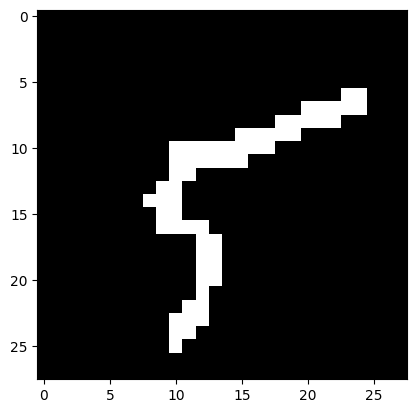

In [ ]:
def rotar(imagen, angulo_rotacion):
    alto, ancho = imagen.shape[:2]
    centro = (ancho // 2, alto // 2)
    matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo_rotacion, 1.0)
    imagen_rotada = cv2.warpAffine(imagen, matriz_rotacion, (ancho, alto))
    return imagen_rotada



angulo_rotacion = 268
x,y=loadDataset("Nmist/mnist_test.csv",100)
indice = 58

print(x.shape)
print(y.shape)
print(y[indice])
digit = x[indice]

digit_pixels = digit.reshape(28, 28)
digit_pixels = digit_pixels.astype(np.uint8)

binary  = thresholdingGlobal(digit_pixels,10)
binary = erosion(dilatacion(binary,kernel),kernel)
img = rotar(binary, angulo_rotacion)
normal = freeman(binary)
print(normal)
rotada = freeman(img)
print(rotada)
print(transform)
plt.imshow(binary, cmap='gray')
plt.show()







In [78]:
# Convierte las listas en arreglos numpy
x_train = np.array(resultados_transform)
y_train = np.array(y)

# Inicializar el clasificador K-NN
knn = KNeighborsClassifier(n_neighbors=10)  # Puedes ajustar el número de vecinos

# Entrenar el clasificador K-NN
knn.fit(x_train, y_train)


KNeighborsClassifier(n_neighbors=10)